# Stable Diffusion API

Last semester we looked at ways to call the SD API through bash scripts. This is not ideal, because we have a lot to learn about writing bash scripts.

Now we focus on using python from a Jupyter notebook to interact with the API running on lambda1.

In [1]:
import hashlib
import requests
import pickle
from PIL import Image
import json
import io
import base64
import matplotlib.pyplot as plt

## Configurations

The computer where the jupyter notebook is running needs to have an ssh tunnel connection to lambda1 where the API is running.

I assume that your sdwebui is running under your port number on lambda1, and the API is available. Since our port numbers start with 71, I will use 71xx to stand for your port number.

In this discussion, the **client** means the computer you are working from, most likely your laptop or desktop computer.

So, we will talk about two possible configurations: notebook is running on the client, or notebook is running on a hub such as dive10.

### Client <-> Lambda1

Open a command prompt on the client and start an ssh tunnel ,ssh -L 71xx:localhost:71xx, between the client and lambda1.

Now if you open a browser on the client and go to localhost:71xx, you can run the GUI.

You can also write python in a notebook running on the client and make calls to the API. As we will see, there are some good reasons to use the API instead of the GUI.

### Client <-> Dive10 <-> Lambda1

In this configuration, you use a browser on the client to interact with the notebook running on dive10.

Now you need an ssh tunnel between dive10 and lambda1. You will not be able to use the GUI in a browser on the client, but you will be able to send API requests from the notebook to lambda1.

### Differences

* The ssh tunnel needs to be from the machine hosting the notebook to lambda1.

* If you create images, they will be sent from lambda1 to the machine hosting the notebook.

* Once you have the tunnel setup, the code you execute in the notebook will be the same for each configuration.

## GET Example

HTTP get calls are used to pull information from the server without sending anything.

In [2]:
resp = requests.get('http://localhost:7101/sdapi/v1/loras')
resp.status_code

200

Status code of 200 is good!

The attribute resp.content shows you raw bytes object that was returned, and it is not very useful.  Here are the first 500 characters:

In [4]:
resp.content[:500]

b'[{"name":"add_detail","alias":"add_detail","path":"/home/brownj/stable-diffusion-webui/models/Lora/add_detail.safetensors","metadata":{}},{"name":"Andy_400","alias":"Andy_400","path":"/home/brownj/stable-diffusion-webui/models/Lora/Andy_400.safetensors","metadata":{"ss_sd_model_name":"epicrealism_naturalSinRC1VAE.safetensors","ss_resolution":"512","ss_clip_skip":"2","ss_tag_frequency":{"Andy":{"alwx":16}},"ss_bucket_info":{"buckets":{"(512, 512, 0)":{"resolution":[512,512],"count":16}}},"modelsp'

The method resp.json() will parse the raw content and return a list of python dict objects:

In [17]:
rj = resp.json()
rj

[{'name': 'add_detail',
  'alias': 'add_detail',
  'path': '/home/brownj/stable-diffusion-webui/models/Lora/add_detail.safetensors',
  'metadata': {}},
 {'name': 'Andy_400',
  'alias': 'Andy_400',
  'path': '/home/brownj/stable-diffusion-webui/models/Lora/Andy_400.safetensors',
  'metadata': {'ss_sd_model_name': 'epicrealism_naturalSinRC1VAE.safetensors',
   'ss_resolution': '512',
   'ss_clip_skip': '2',
   'ss_tag_frequency': {'Andy': {'alwx': 16}},
   'ss_bucket_info': {'buckets': {'(512, 512, 0)': {'resolution': [512, 512],
      'count': 16}}},
   'modelspec.title': 'LoRA@1701282728.425136',
   'ss_lr_scheduler': 'constant_with_warmup',
   'modelspec.resolution': '512x512',
   'ss_epoch': '25',
   'ss_max_token_length': '75',
   'modelspec.sai_model_spec': '1.0.0',
   'modelspec.architecture': 'stable-diffusion-v1/lora',
   'ss_learning_rate': '2e-06',
   'ss_min_snr_gamma': '0',
   'modelspec.prediction_type': 'epsilon',
   'modelspec.date': '2023-11-29T13:32:08',
   'modelspec.t

In [19]:
for i,n in enumerate(rj):
    print(i,n['name'])

0 add_detail
1 Andy_400
2 Andy_800
3 Andy_1200
4 Andy_1600
5 charturnerv2
6 Joker
7 LowRA
8 mix4


In [20]:
joker = rj[6]
joker

{'name': 'Joker',
 'alias': 'Joker',
 'path': '/home/brownj/stable-diffusion-webui/models/Lora/Joker.safetensors',
 'metadata': {'ss_sd_model_name': 'v1-5-pruned-emaonly.safetensors',
  'ss_resolution': '(512, 512)',
  'ss_clip_skip': '2',
  'ss_num_train_images': '3000',
  'ss_tag_frequency': {'100_The Joker': {'the joker the joker a man dressed as the joker sitting on a stair': 2,
    'the joker the joker a close up of a person with a clown makeup': 4,
    'the joker the joker a man dressed as a joker with a green hair': 2,
    'the joker the joker a man with a clown makeup on his face': 2,
    'the joker the joker a man dressed as the joker smoking a cigarette': 2,
    'the joker the joker a man dressed as a joker with a red jacket and green tie': 2,
    'the joker the joker a man dressed in a red suit and yellow vest': 2,
    'the joker the joker a close up of a person with a clown face': 2,
    'the joker the joker a man dressed as the joker in a crowd': 2,
    'the joker the joke

In [6]:
!date -d @1677581498.3846705

Tue Feb 28 05:51:38 AM EST 2023


In [26]:
# start
s=float(joker['metadata']['ss_training_started_at'])

# finish
f=float(joker['metadata']['ss_training_finished_at'])

# time
t = f-s

print(s,f,t)

1680023765.447559 1680025385.1115916 1619.664032459259


The numbers s and f are linux timestamps, the number of seconds since the **epoch:** 12:00 am, January 1, 1970.

t is the number of seconds from start to finish.

I will use the datetime package to see the dates.

In [27]:
from datetime import datetime

print(datetime.fromtimestamp(s))
print(datetime.fromtimestamp(f))
print(datetime.fromtimestamp(f) - datetime.fromtimestamp(s))

2023-03-28 13:16:05.447559
2023-03-28 13:43:05.111592
0:26:59.664033


In [28]:
t/60

26.99440054098765

In [29]:
0.9944*60

59.663999999999994

## Post Example

HTTP post calls are used to send information and get a response.

I will make a post request to call txt2img:

In [30]:
resp = requests.post(url=f'http://localhost:7101/sdapi/v1/txt2img',
                     json={'prompt':'cute austrailian shepherd puppy','batch_size':4})
resp.status_code

200

In [31]:
rj = resp.json()
type(rj)

dict

In [32]:
rj

{'images': ['iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAAA43RFWHRwYXJhbWV0ZXJzAGN1dGUgYXVzdHJhaWxpYW4gc2hlcGhlcmQgcHVwcHkKU3RlcHM6IDUwLCBTYW1wbGVyOiBFdWxlciwgQ0ZHIHNjYWxlOiA3LjAsIFNlZWQ6IDIxMzkyODU1NTUsIFNpemU6IDUxMng1MTIsIE1vZGVsIGhhc2g6IDE1MDEyYzUzOGYsIE1vZGVsOiByZWFsaXN0aWNWaXNpb25WNTFfdjUxVkFFLCBEZW5vaXNpbmcgc3RyZW5ndGg6IDAsIFZlcnNpb246IHYxLjYuMC0yLWc0YWZhYWY4Yad9Am4AAQAASURBVHicjP3tduRIriwKmgHOUFbPmre6a97/WU5XpRR0B2x+AE5Sytr73OhqpRTB4CccMBi++P/7f/4fkCTHcHc3MxqHDXNzH+bD/aA5zc0Os+E+zF/uL5ibv+gvHx82Dj8+bLzG8cvHy49jjOHHGGOM4T5obiRJgAZQJACCAAFAEID+o1/7vf4DrB8AoHtrQgLI2oSQwN7lvUN93/OfL/4v2/xvn10f/8ufPz7Yb/LH3/+3c61L0/f3+fhFeN6JP0977/xxKP4vd+M+zo+d3rvitwe2jw8C0n1qAkASgASp9kMoEYlMSRm5ckWuFTEjQmvlmsqlXLFmxlIs5cqcqchIZGZEZqSmMgGkCDE56C/zl41jjNd4fYzXx+vjY7wOPw4bbu5mpmRErhVrvuf5Xu+veX7F+2u9P7U+c34qPmO9FW/kFziBgJbmrINCgkAyAchpnhy0X+YfNn6Z//Lx1zj+P368fHz48RrHxzjcx3B3czc3cyedbmakkaTRQJJOGlC/X+8QBqPRjKQbzUTSCJKqR8q+x1L/Vc9lPwbtByD8lMY/JE+1S/2L1F4CdH8kkN//3JKh/1W8HnvRQ27Q537JlZ5b/LEH/Jusb4ktob1

In [33]:
imgs = []

for i in rj['images']:
    imgs.append(Image.open(io.BytesIO(base64.b64decode(i.split(",",1)[0]))))
    
len(imgs)

4

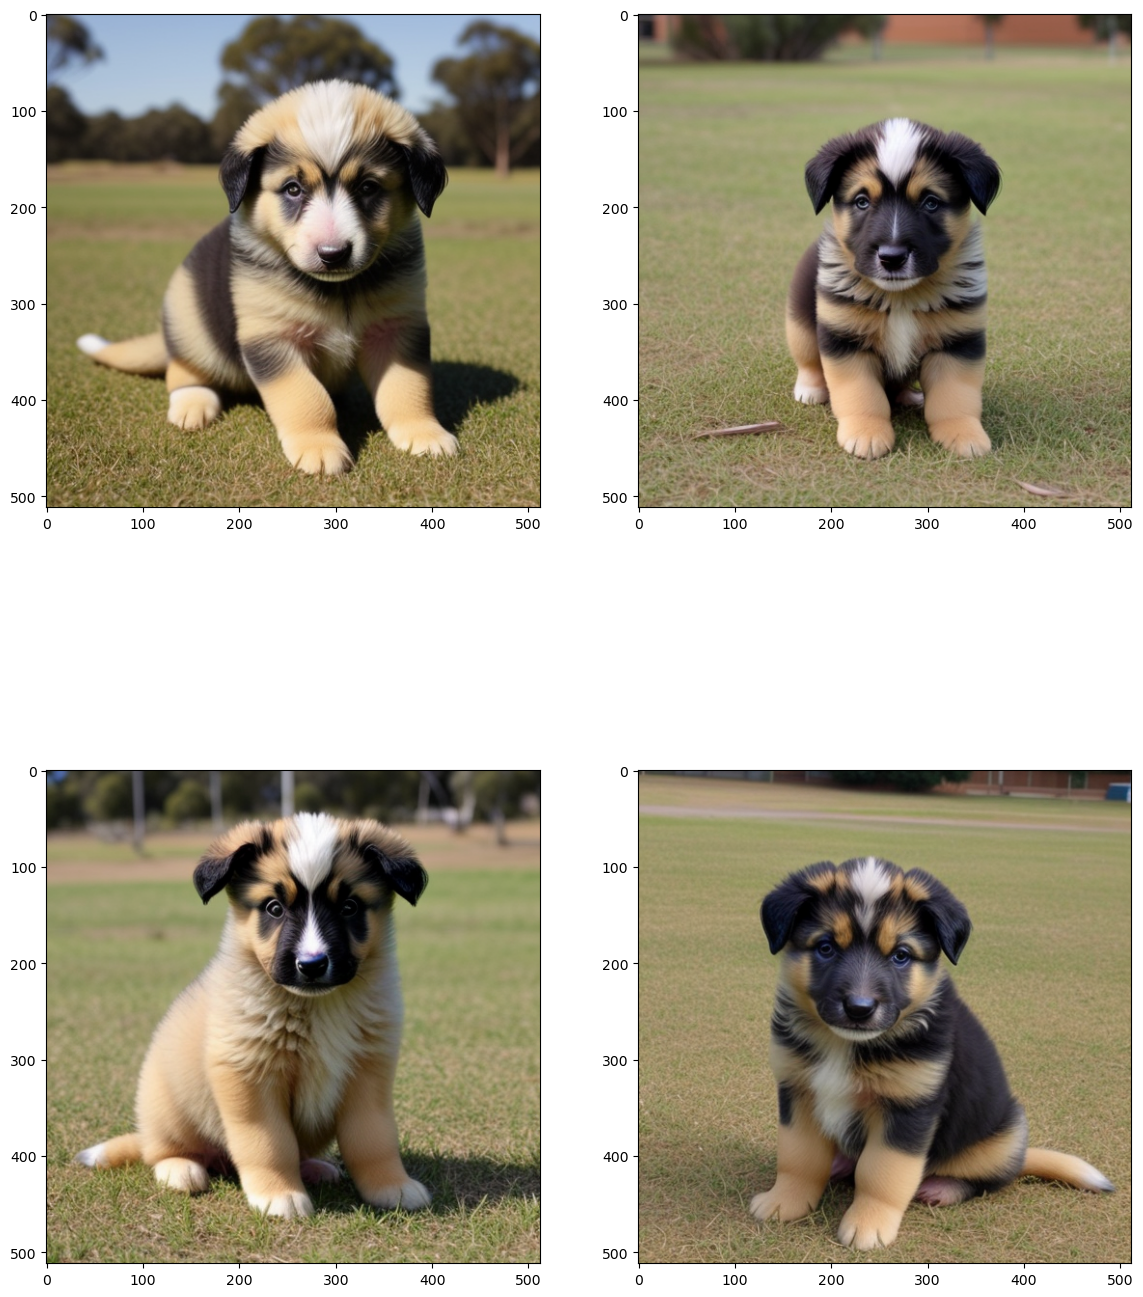

In [34]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(14,18))

for r in [0,1]:
    for c in [0,1]:
        ax[r,c].imshow(imgs[2*r+c])